# Colegio de Postgraduados Campus Montecillo
## Posgrado en Socioeconomía, Estadística e Informática
## Cómputo Aplicado

## Entrenamiento de los datos de aguacates con <i>Multilayer Perceptron </i> 

Por: Ulises Enrique Campos Ferreira

### Paso 1: Importar las librerías necesarias 

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

### Paso 2: Definir la ruta de trabajo 

In [10]:
ruta2 = "/Users/campos/Documents/COA 690/Segundo entrenamiento/"

os.chdir(ruta2)

### Paso 3: Leer el conjunto de datos 

In [11]:
datos = pd.read_csv(ruta2 + 'Datos salida.csv') # BD1
#datos = pd.read_csv(ruta2 + 'BD135 ClssInv.csv') # BD2

In [12]:
datos.head()

img_name    R    G   B   H    S    V  y
0  Fruto 31.jpg  109  139  43  39  176  139  0
1  Fruto 31.jpg  111  141  43  39  177  141  0
2  Fruto 31.jpg  112  142  44  39  176  142  0
3  Fruto 31.jpg  112  142  46  39  172  142  0
4  Fruto 31.jpg  116  143  48  39  169  143  0

El conjunto de imágenes utilizadas corresponden 90 imágenes (30 imágenes por clase objetivo) correspondiente a un [conjunto de datos más grande](https://www.kaggle.com/datasets/camposfe1/clasifiacin-de-enfermedades-del-aguacatero). 

Estas imágenes se encontraban en el espacio de color RGB (<i>Red</i>, <i>Green</i>, <i>Blue</i>), pero se transformaron al espacio de color HSV (<i>Hue</i>, <i>Saturation</i>, <i>Value</i>), debido a que en entrenamientos internos, así como en la literatura, se obtuvieron precisiones mayores.

Se tienen las dos bases de datos en el cuadro de código anterior, <b>BD1</b> corresponde al conjunto de datos de selección por región, donde, a partir de un pixel semilla, se obtendrán los pixeles por similaridad de manera automática. Para <b>BD2</b> corresponde a la técnica de selección por submuestreo; es decir, se hicieron recortes de 30 $\times$ 30 píxeles a las áreas de interés de cada imagen.

Debido a que la mejor extracción de características fue <b>BD1</b>, solamente se hizo el entrenamiento con esta técnica de extracción.

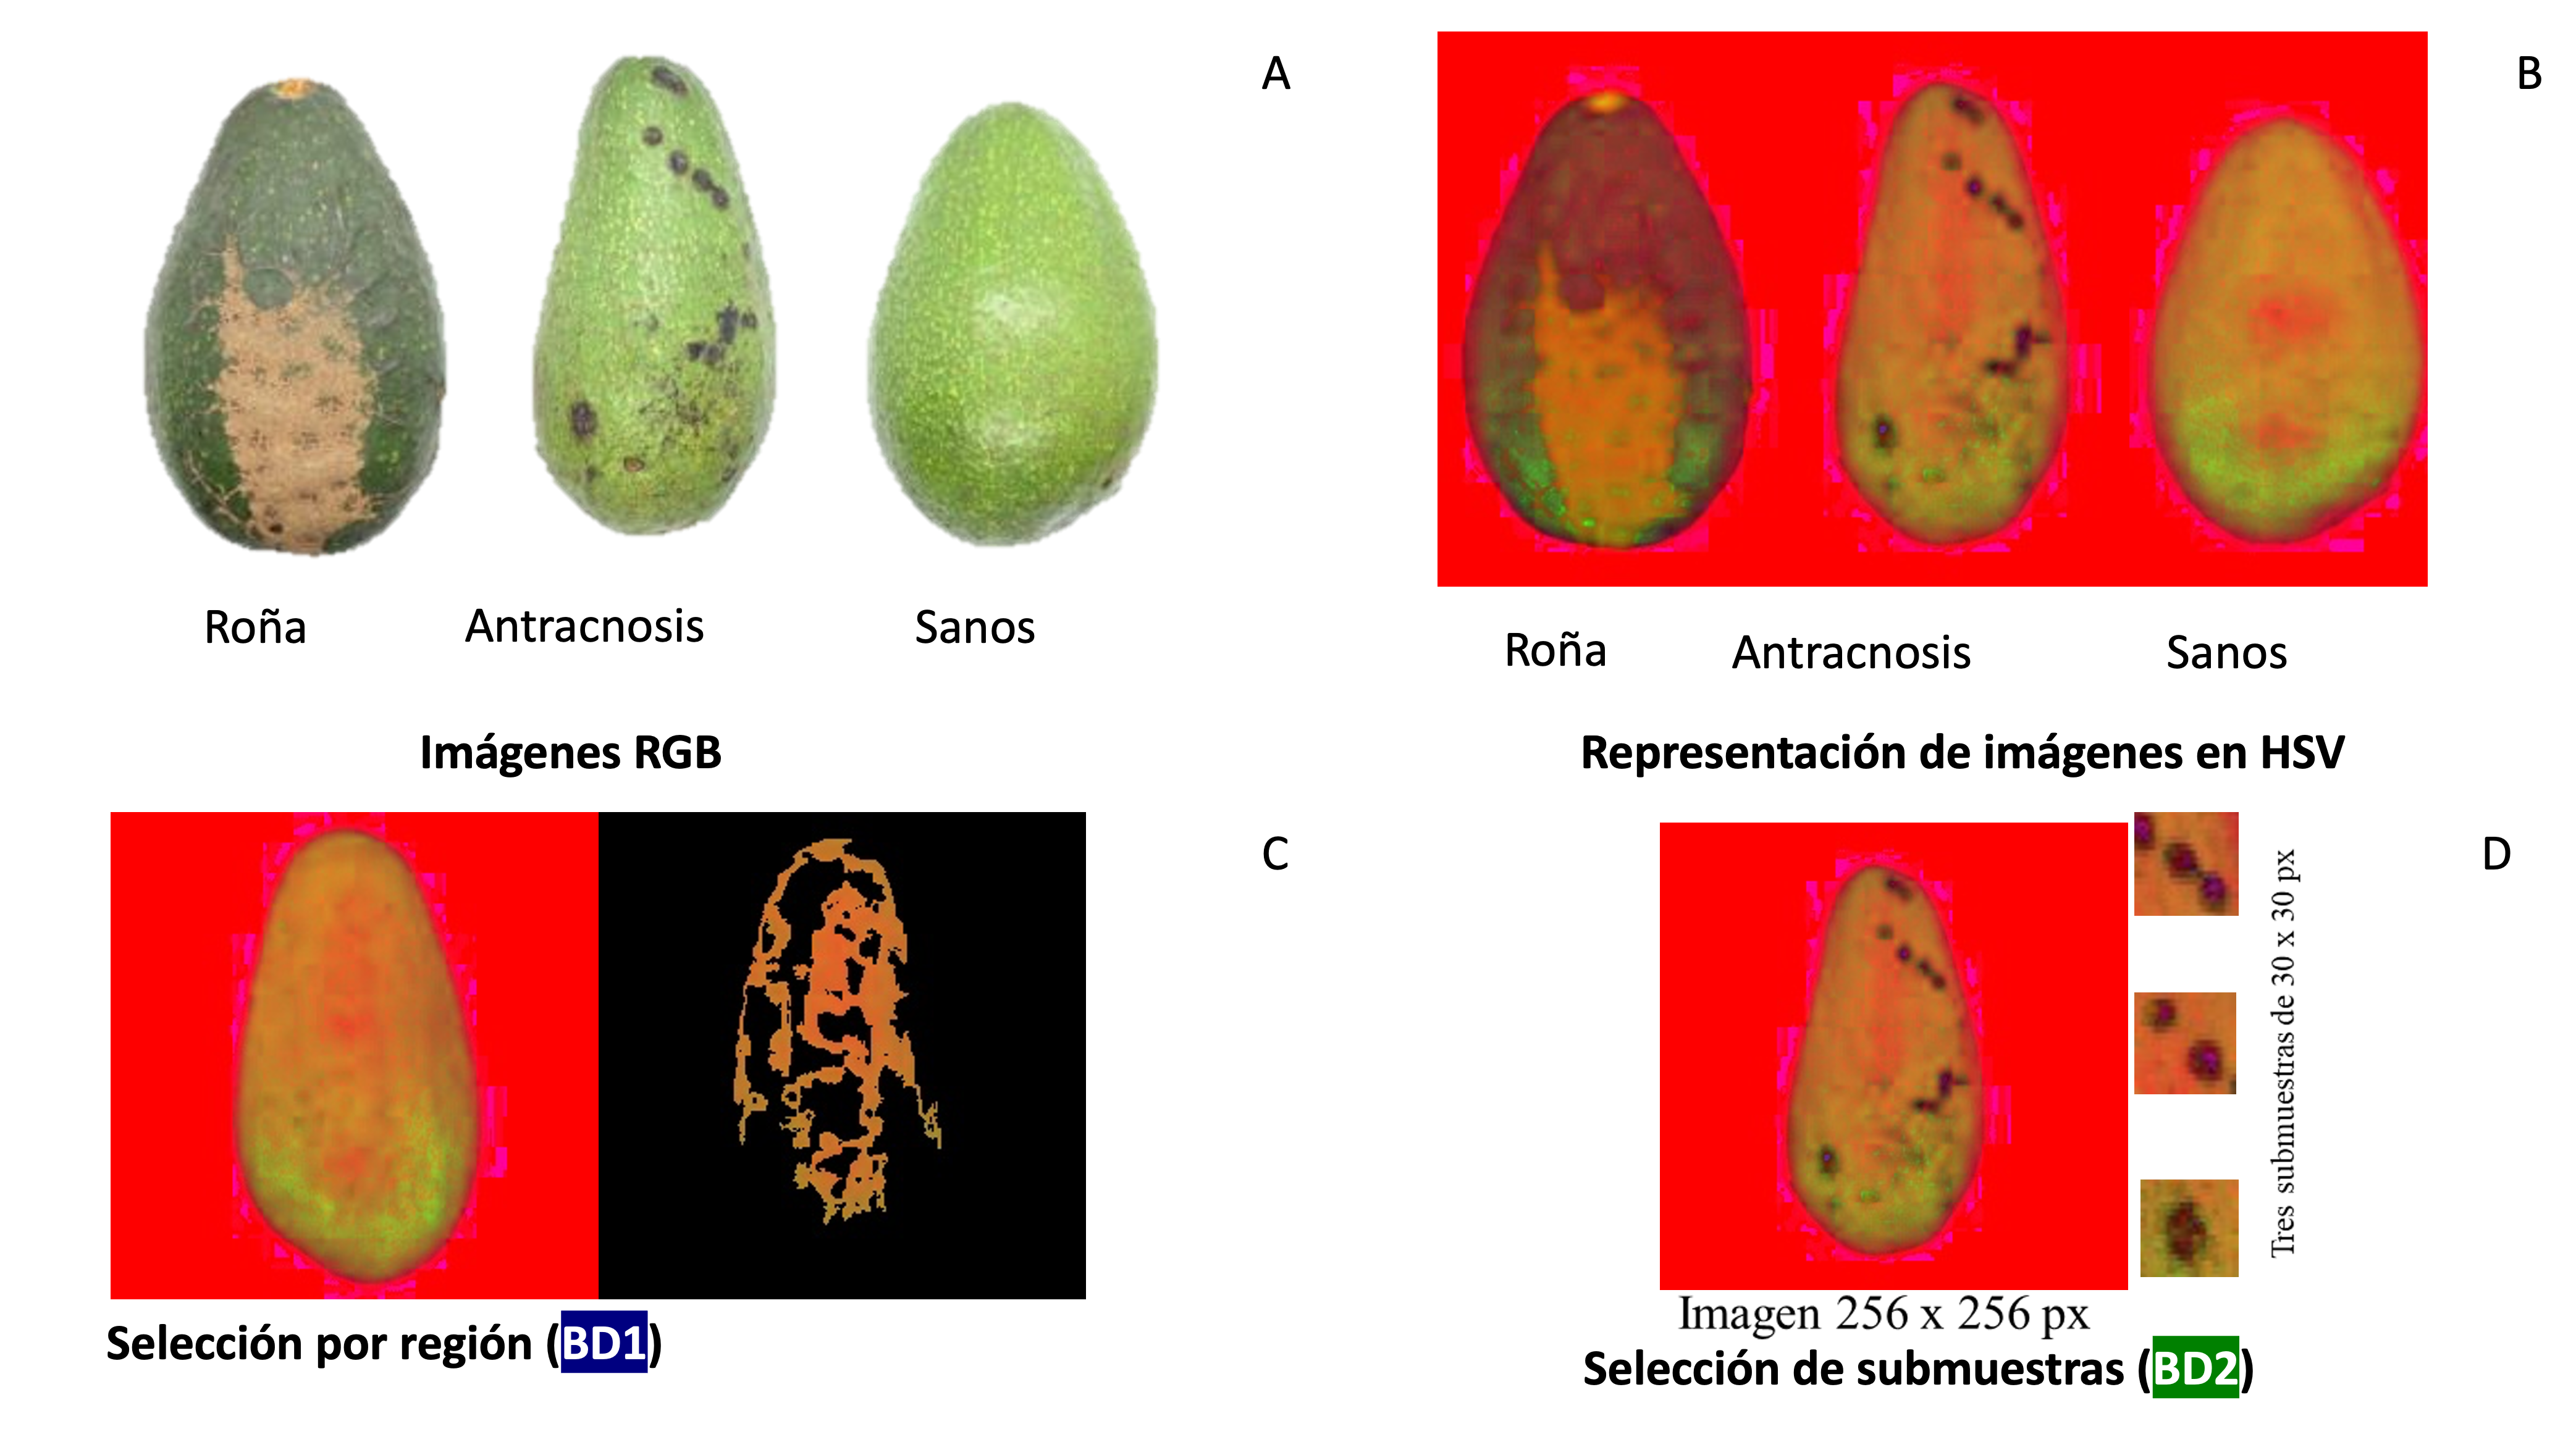 

### Figura 1. Conjunto de datos utilizado para el presente trabajo. A. Muestra de las tres clases de interés en el espacio de color RGB; B. Imágenes transformadas en el espacio de color HSV; C. Muestra de la extracción de características utilizando la técnica de selección por región; D. Extracción de características utilizando la técnica de submuestreo.

### Paso 4: Definir las obersvaciones y las variables respuesta 

In [4]:
X = datos.iloc[:, 4:7].values #BD1
y = datos.iloc[:, 7].values #BD1

El valor `X` corresponde a los valores de las tripletas HSV, y en el caso de `y`a la variable respuesta, donde el valor $0$ corresponde a la clase de frutos sanos; $1$ a los frutos con roña y $2$ a los frutos con antracnosis.

### Paso 5: Realizar la partición de datos

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

Para este caso, se realizó una partición de los datos de tipo $80:20$; es decir, que el $80 \%$ de los datos pertenecerán al conjunto de datos de entrenamiento, y el $20 \%$ restante al conjunto de prueba. Debido a que existe un ligero desbalance entre los valores de cada clase, se utiliza el parámetro `stratify = y`, lo cual indica que tomará las proporciones adecuadas para cada una de las clases objetivo. 

### Paso 6: Optimización de los hiperparámetros con `grid_search` y validación cruzada

In [ ]:
modelo = MLPClassifier(random_state=1)

# =============================================================================
# Búsqueda por retícula para encontrar los mejores hiperparámetros
# =============================================================================

# Se define un rango de valores para cada hiperparámetro de interés

batch_size = [8, 16, 32]

param_grid = {
    'hidden_layer_sizes': [(50), (100), (150)], #Una sola capa intermedia
    'max_iter': [50, 100, 500],
    'activation': ['softmax', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'learning_rate': ['constant','adaptive'],
    'batch_size': [8, 16, 32]
}

gs = GridSearchCV(modelo, 
                  param_grid,scoring='accuracy', 
                  n_jobs= -1,
                  refit = True,
                  cv=10)

gs = gs.fit(X_train, y_train)

# Imprime los mejores hiperparámetros del modelo

gs.best_params_

Lo primero que se necesita hacer es la inicialización del modelo, definiendo los hiperparámetros por defecto y una semilla para tener resultados reproducibles.

Posteriormente, se definen los rangos de hiperparámetros a evaluar guardándolo en la variable `param_grid`.

Después se utiliza la función `GridSearchCV`, la cuál tomará como argumentos al modelo inicializado, el rango de hiperparámetros a evaluar, la forma en el que se tendrá la mejor combinación, que en este caso fue el <i>accuracy</i> y la validación cruzada de $10$.

La validación cruzada consiste en lo siguiente: al conjunto de entrenamiento, se harán $k$ particiones definidas por el usuario, que, para este caso fue $k=10$; entonces el conjunto se dividirá en 10 partes con datos disjuntos; es decir, que en ninguna partición habrán datos de otras particiones. \
Para $k-1$ pertenecerán al conjunto de datos de entrenamiento, y el restante será el conjunto de prueba. Debido a que es un proceso iterativo, el conjunto de datos pasará a la siguiente partición, y así sucesivamente.\
Entonces, esto se repetirá para cada una de las combinaciones definidas, y al final se obtendrán los mejores hiperparámetros.

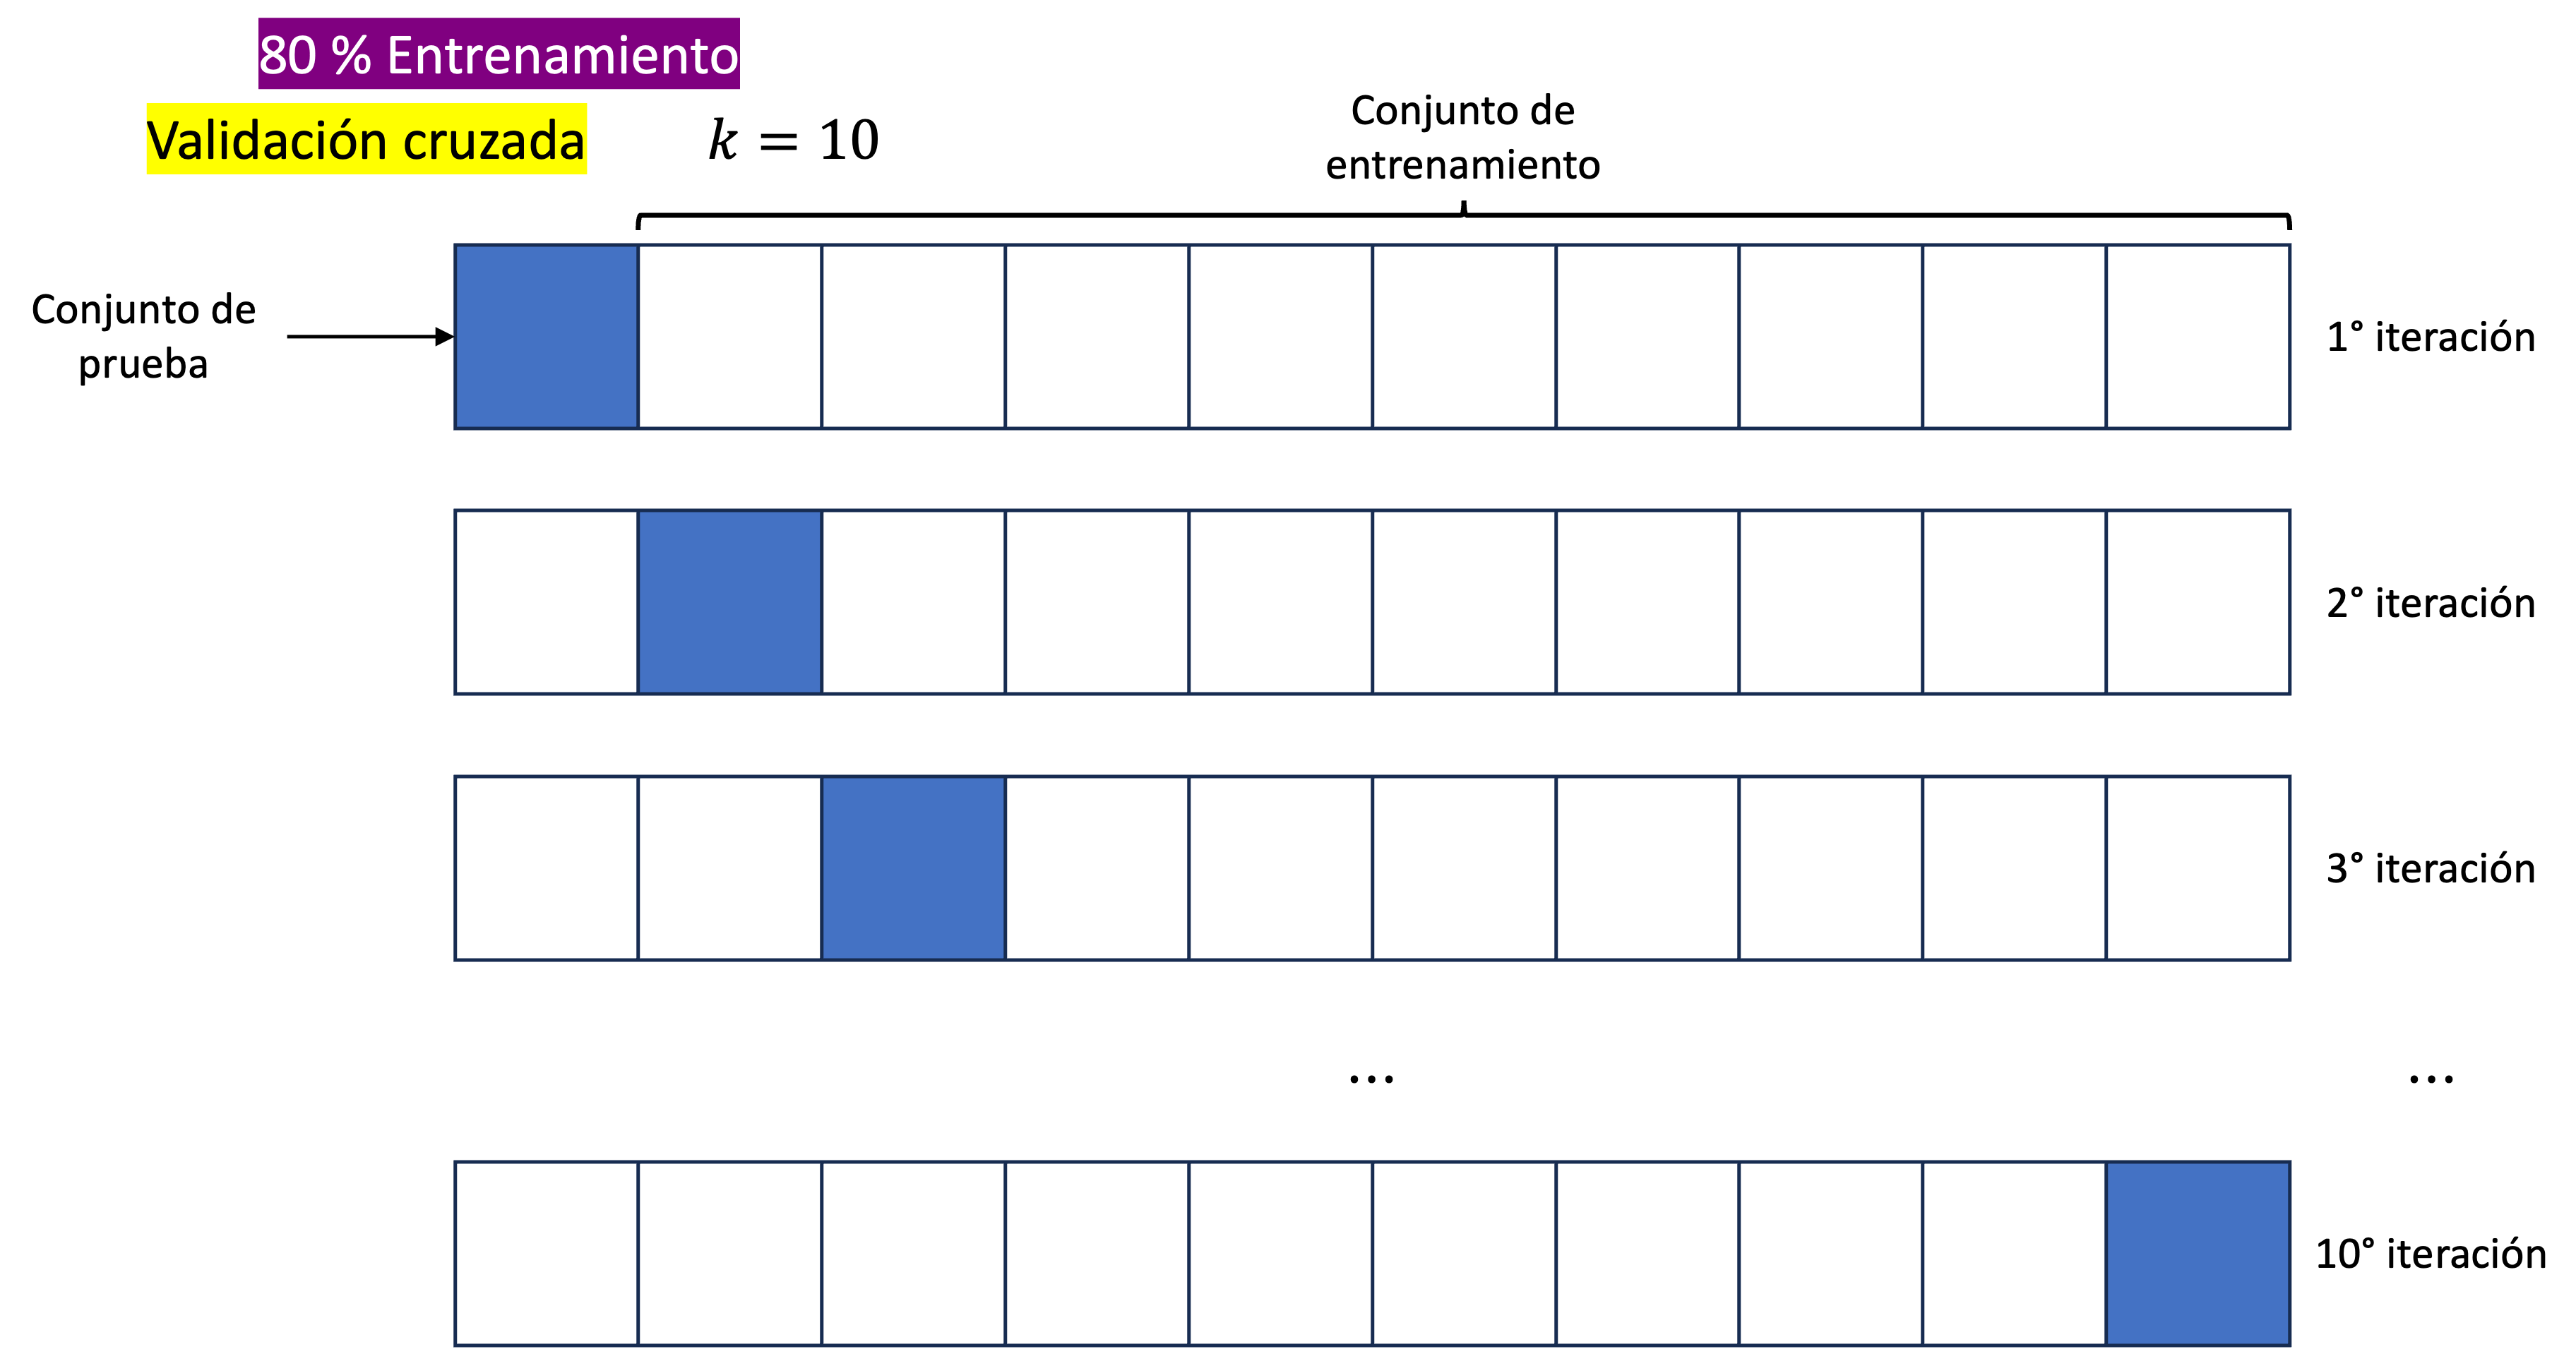 

### Figura 2. Ejemplo de una validación cruzada $k = 10$ 

### Paso 6: Nuevo entrenamiento con los mejores hiperparámetros 

In [6]:
modelo = make_pipeline(StandardScaler(),
                       MLPClassifier(random_state=1,
                       batch_size = 16,
                       hidden_layer_sizes=150,
                       activation='relu', 
                       max_iter=50, 
                       solver='adam', 
                       learning_rate="constant"))

Con base a los mejores hiperparámetros obtenidos, se define un nuevo modelo. Para este caso, se utilizará el conjunto de datos completo; es decir, `X`, y se hará una nueva validación cruzada, en donde se obtendrán las `accuracy` de cada una de las particiones, y la `accuracy` más alta será la que muestre las métricas de desempeño, así como la matriz de confusión y los valores de la AUC

Accuracy para el pliegue 0: 0.96 
Accuracy para el pliegue 1: 0.87 
Accuracy para el pliegue 2: 0.98 
Accuracy para el pliegue 3: 0.94 
Accuracy para el pliegue 4: 0.90 
Accuracy para el pliegue 5: 0.98 
Accuracy para el pliegue 6: 0.94 
Accuracy para el pliegue 7: 0.97 
Accuracy para el pliegue 8: 0.95 
Accuracy para el pliegue 9: 0.94 

Mejor pliegue: 2, Accuracy: 0.98
Desviación estándar: (+/-) 0.03

Métricas de desempeño para el mejor pliegue:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1467
           1       1.00      0.97      0.98      1386
           2       1.00      0.97      0.98      1188

    accuracy                           0.98      4041
   macro avg       0.98      0.98      0.98      4041
weighted avg       0.98      0.98      0.98      4041


Matriz de confusión para el mejor pliegue:


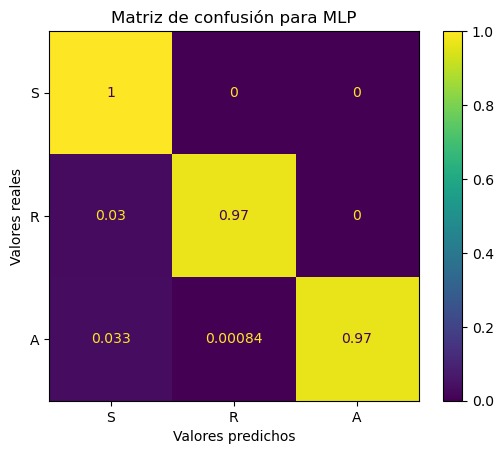

AUC para la clase 0: 1.00
AUC para la clase 1: 1.00
AUC para la clase 2: 1.00


In [7]:
best_accuracy = 0
best_fold = 0
best_auc = 0.0
pliegues = []

# Obtiene las predicciones y el classification report para cada validación
for i, (train_index, test_index) in enumerate(StratifiedKFold(10).split(X, y)):
    # Separa los datos en conjuntos de entrenamiento y prueba para la i-ésima validación
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Entrena el modelo con los datos de entrenamiento
    modelo.fit(X_train_cv, y_train_cv)

    # Haz predicciones en los datos de prueba
    y_pred = modelo.predict(X_test_cv)
    
    # Haz predicciones y calcular la pertenencia para cada clase
    y_pred_proba = modelo.predict_proba(X_test_cv)

    # Calcula el accuracy para las predicciones
    accuracy = accuracy_score(y_test_cv, y_pred)
    
    # Calcula el AUC para las predicciones
    auc = roc_auc_score(y_test_cv, y_pred_proba, average = None, multi_class = 'ovr')

    # Actualiza el mejor fold si el accuracy actual es mayor que el anterior
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i
        best_report = metrics.classification_report(y_test_cv, y_pred)
        etiquetas = ["S", "R", "A"]
        matriz_c = confusion_matrix(y_test_cv, y_pred, 
                                    labels = modelo.classes_,
                                    normalize = 'true' )
        display = ConfusionMatrixDisplay(confusion_matrix = matriz_c,
                                 display_labels = etiquetas)
        best_auc = auc
        

    # Imprime el accuracy para la i-ésima validación
    print("Accuracy para el pliegue %d: %0.2f " % (i, accuracy))
    
    #Guardar los ACC de cada pliegue
    pliegues.append(accuracy)

# Imprime el fold con el mejor accuracy
print("\nMejor pliegue: %d, Accuracy: %0.2f" % (best_fold, best_accuracy))
print("Desviación estándar: (+/-) %0.2f" % np.std(pliegues))

# Imprime el classification report para el mejor fold
print("\nMétricas de desempeño para el mejor pliegue:")
print(best_report)

print("\nMatriz de confusión para el mejor pliegue:")

fig, ax = plt.subplots()
display.plot(ax=ax)
ax.set_title("Matriz de confusión para MLP")
ax.set_ylabel("Valores reales")
ax.set_xlabel("Valores predichos")
plt.show()

# Imprime el AUC para cada clase en el mejor fold
for clase, auc_score in zip(modelo.classes_, best_auc):
    auc_formatted = "{:.2f}".format(auc_score)
    print(f"AUC para la clase {clase}: {auc_formatted}")


Con base a los resultados obtenidos, el mejor pliegue fue el 2 con un `Accuracy` de $0.98$.

En caso de que se desee revisar los resultados con BD2, solamente es cambiar los valores donde se tienen los comentarios.

### Paso 7: Guardar el modelo 

<b> IMPORTANTE </b> para el funcionamiento de los modelos guardados, es necesario contar con la versión de `sklearn == 0.21.3`

In [8]:
import pickle

ruta_guardado = "/Users/campos/Documents/COA 690/Segundo entrenamiento/Modelos optimizados/"
os.chdir(ruta_guardado)

pickle.dump(modelo, open('MLP_mejor_fold.pkl', 'wb'))